In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./data/bq-results-20241223-153559-1734968168534.csv')
df = df[~df['missionCatalog_id'].isin(['f1455712-fa2b-4feb-b7f9-ab8ddfa29e8d', 'd090d147-1ac9-4963-9c2b-1f5e663bad44'])]

df.rename(columns={'sub': 'user', 'missionCatalog_id': 'missionID'}, inplace=True)
df['mission'] = df['kind'] + '_' + df['TARGET'].astype(str)

df = df[['user', 'missionID', 'createdAt', 'kind', 'TARGET', 'performance']]
df = df.groupby('user').filter(lambda x: x['createdAt'].nunique() > 7)
df['createdAt'] = pd.to_datetime(df['createdAt']).dt.date

df['user'] = df['user'].astype('category').cat.codes
df['missionID'] = df['missionID'].astype('category').cat.codes
df['kind'] = df['kind'].astype('category')

def reward(x):
    if x <= 1:
        return x
    return max(0, 2 - x**2)

df['reward'] = df['performance'].apply(reward)

df.sort_values(by=['createdAt', 'user'], inplace=True, ignore_index=True)
df

,user,missionID,createdAt,kind,TARGET,performance,reward
0,4,26,2024-10-02,quiz,2,2.500000,0.0
1,4,28,2024-10-02,episode,3,2.333333,0.0
2,4,6,2024-10-02,activity,8,2.125000,0.0
3,4,14,2024-10-02,activity,10,1.700000,0.0
4,4,18,2024-10-02,exp,50,3.200000,0.0
...,...,...,...,...,...,...,...
186390,1883,12,2024-12-22,episode,5,1.600000,0.0
186391,1883,18,2024-12-22,exp,50,1.700000,0.0
186392,1884,0,2024-12-22,episode,2,2.500000,0.0
186393,1884,10,2024-12-22,quiz,1,126.000000,0.0


In [2]:
x = df.groupby(['user', 'missionID'])['reward'].agg(['mean', 'count'])
x['mean']

user  missionID
0     0            0.000000
      1            0.185185
      2            0.000000
      3            0.000000
      4            0.000000
                     ...   
1897  21           0.000000
      22           0.500000
      25           0.166667
      27           0.500000
      28           0.500000
Name: mean, Length: 48913, dtype: float64

In [3]:
n_users = df['user'].nunique()
n_missions = df['missionID'].nunique()

print(f'Number of users: {n_users}')
print(f'Number of missions: {n_missions}')

print(df['kind'].cat.categories)

Number of users: 1898
Number of missions: 30
Index(['action', 'activity', 'episode', 'exp', 'mobility', 'quiz'], dtype='object')


<Axes: xlabel='missionID'>

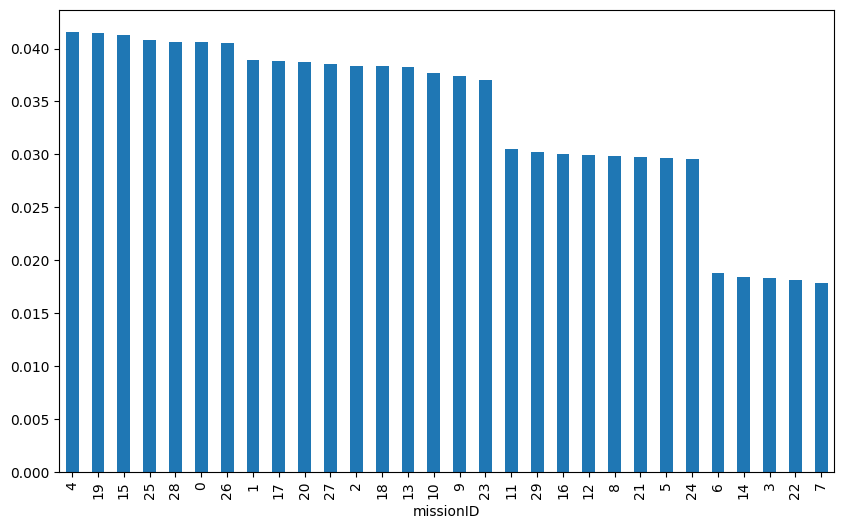

In [7]:
plt.figure(figsize=(10, 6))

df['missionID'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
df['performance'].apply(lambda x: x >= 1).value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=['Failed', 'Succeeded'])

In [ ]:
plt.figure(figsize=(10, 6))

df.groupby('kind', observed=True).size().plot(kind='bar')

In [ ]:
df.groupby('user', observed=True)['createdAt'].nunique().plot.hist(bins=50,title='Number of missions per user',xlabel='Number of missions',ylabel='Number of users')

In [ ]:
import numpy as np

def reward(x):
    if x <= 1:
        return x
    return np.maximum(0, 2 - np.power(x, 2))

x = np.linspace(0, 2, 100)
y = [reward(i) for i in x]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.title('Value of reward function over performance', fontsize=20)
plt.plot(x, y, label='Reward')
plt.fill_between(x, [1] * len(x), alpha=0.3, color='#E66100', where = x >= 1, label='Mission with overshoot')
plt.fill_between(x, [1] * len(x), alpha=0.3, color='#5D3A9B', where = x <= 1, label='Mission failed')
plt.legend(fontsize=12)
plt.xlabel('Observed performance (relative to target)', fontsize=14)
plt.ylabel('Reward value', fontsize=14)
plt.grid()
plt.savefig('out/reward_function.pdf', format='pdf')
plt.show()